### Single Object Detection: IGrand Challenge

- Exploratory data analysis
- Data transformation for object detection
- Creating custom datasets
- Creating the model
- Defining the loss, optimizer, and IOU metric
- Training and evaluation of the model
- Deploying the model

In [1]:
import pandas as pd
import os

path2data = "./"

path2labels = "./Fovea_location.xlsx"


In [4]:
labels_df = pd.read_excel(path2labels, index_col='ID')

In [6]:
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [7]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


<AxesSubplot:ylabel='Fovea_Y'>

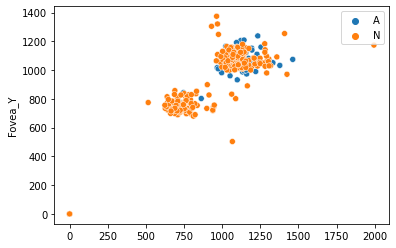

In [15]:
import seaborn as sns
%matplotlib inline

AorN = [inm[0] for inm in labels_df.imgName]
sns.scatterplot(x = labels_df.Fovea_X.values, y = labels_df.Fovea_Y, hue = AorN)

In [20]:
import collections
counter = collections.Counter(AorN)
print(counter)

Counter({'N': 311, 'A': 89})


In [21]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [45]:
plt.figure(figsize = (15,15))
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
nrows, ncols = 2,3
img_name = labels_df["imgName"]
ids = labels_df.index
rndIds = np.random.choice(ids, nrows*ncols)
print(rndIds)

[ 33 390 102 146 233 379]


<Figure size 1080x1080 with 0 Axes>

In [46]:
def load_img_label(label_df, id_):
    imgName = labels_df["imgName"]
    if imgName[id_][0] == 'A':
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
    path = os.path.join(path2data, "Training400", prefix, imgName[id_])
    
    img = Image.open(path)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x,y)
    
    return img, label


In [47]:
def show_img_label(img,label, w_h = (50,50), thickness = 2):
    w,h = w_h
    cx, cy = label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline = "green", width = thickness)
    plt.imshow(np.asarray(img))
    


(2124, 2056) (1056.61757612318, 1083.18581358541)
(1444, 1444) (650.344414445092, 764.439839270357)
(2124, 2056) (1070.72155670707, 1020.19577258252)
(1444, 1444) (685.151708683473, 734.432299465241)
(1444, 1444) (795.834280782885, 696.418082782058)
(1444, 1444) (798.447672697854, 829.182764075428)


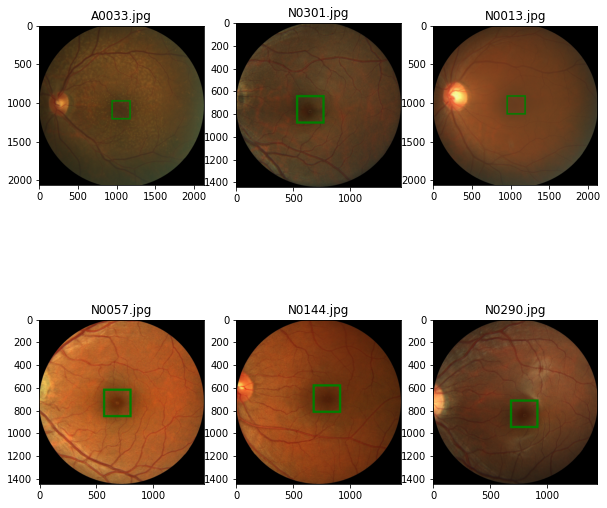

In [50]:
plt.figure(figsize=(10,10))
for i, id_ in enumerate(rndIds):
    img, labels = load_img_label(labels_df, id_)
    print(img.size, labels)
    plt.subplot(nrows, ncols, i+1)
    show_img_label(img, labels, w_h = (250,250), thickness=20)
    img_name = labels_df['imgName']
    plt.title(img_name[id_])

In [56]:
h_list, w_list = [], []

for i in labels_df.imgName:
    if i[0] == 'A':
        prefix = 'AMD'
    else:
        prefix = 'Non-AMD'
    path = os.path.join(path2data, "Training400", prefix, i)
    
    img = Image.open(path)
    h,w = img.size
    h_list.append(h)
    w_list.append(w)

Text(0.5, 1.0, 'Height')

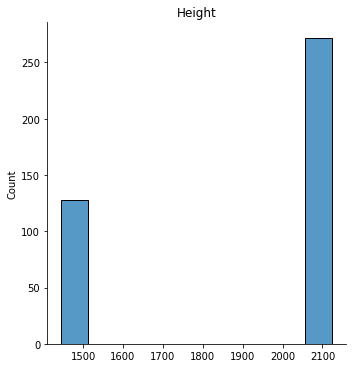

In [65]:
sns.displot(h_list)
plt.title('Height')

Text(0.5, 1.0, 'Width')

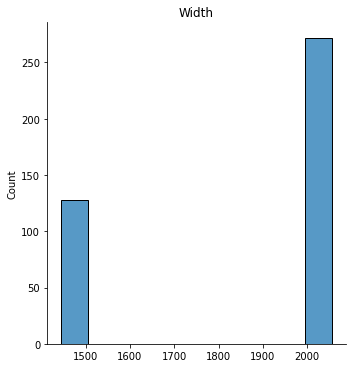

In [64]:
sns.displot(w_list)
plt.title('Width')

## Data Transformation

In [69]:
import torchvision.transforms.functional as TF

def resize_img_label(image, label = (0.0,0.0), target_size = (256,256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx,cy = label
    image_new = TF.resize(img,target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new, label_new

(1444, 1444) (798.447672697854, 829.182764075428)
(256, 256) (141.5530500073758, 147.00193047320607)


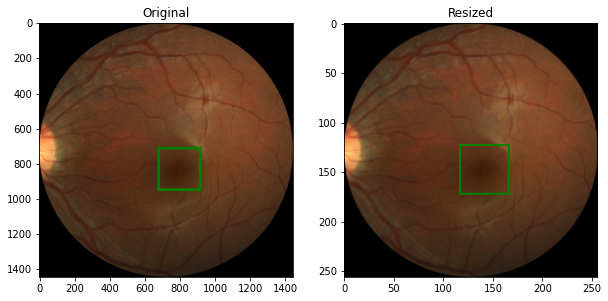

In [82]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, lable)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, lable_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=15)


plt.subplot(1,2,2)
plt.title('Resized')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)

In [90]:
def random_vflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.vflip(image)
    label = x, h-y
    
    return image, label


(1444, 1444) (798.447672697854, 829.182764075428)
(256, 256) (141.5530500073758, 147.00193047320607)


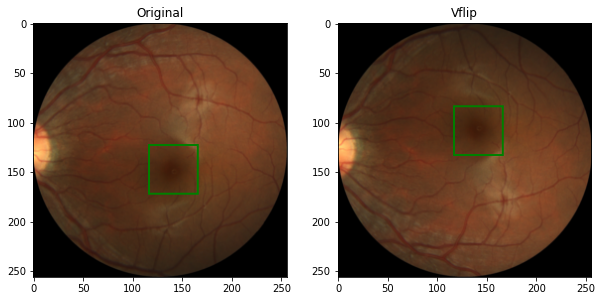

In [91]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, lable)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, lable_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Vflip')
img_v, label_v = random_vflip(img_r, label_r)
show_img_label(img_v,label_v, w_h=(50,50), thickness=2)

In [84]:
def random_hflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.hflip(image)
    label = w-x, y
    
    return image, label


(1444, 1444) (798.447672697854, 829.182764075428)
(256, 256) (141.5530500073758, 147.00193047320607)


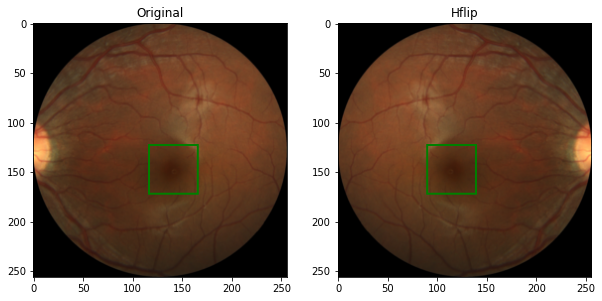

In [92]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, lable)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, lable_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Hflip')
img_h, label_h = random_hflip(img_r, label_r)
show_img_label(img_h,label_h, w_h=(50,50), thickness=2)

In [136]:
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate = (0.2,0.2)):
    w,h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2-1
    w_t = int(max_t_w*trans_coef*w)
    h_t = int(max_t_h*trans_coef*h)
    
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    
    label = (cx + w_t, cy+h_t)
    
    return image, label
    
    
    

(1444, 1444) (798.447672697854, 829.182764075428)
(256, 256) (141.5530500073758, 147.00193047320607)


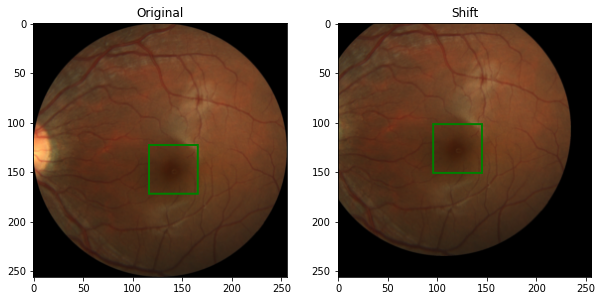

In [137]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, lable)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, lable_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Shift')
img_s, label_s = random_shift(img_r, label_r, max_translate=(.5,.5))
show_img_label(img_s,label_s)

### Custom Transformer

In [143]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    image = TF.to_tensor(image)
    return image, label

In [142]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.2,0.2)
}

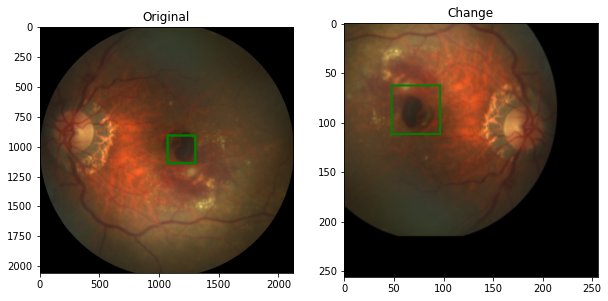

In [150]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [154]:
#Adding Brightness, contrast, gamma correction to prev transformer
# We also define scale label to limit them in (0,1)

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image, brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image = TF.adjust_contrast(image, contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma = 1+(np.random.rand()*2-1)*params["gamma"]
        image = TF.adjust_gamma(image, gamma)
    if params["scale_label"]:
        label = scale_label(label, params['target_size'])   
    
    image = TF.to_tensor(image)
    return image, label



In [156]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.5,0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False
}

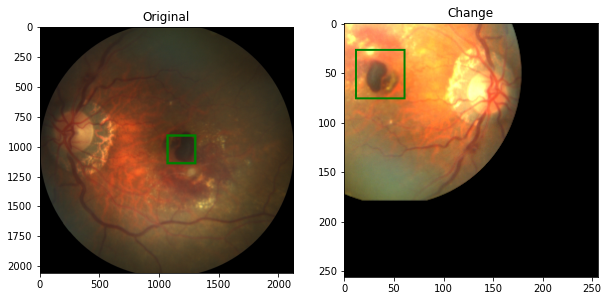

In [160]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [161]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

### Creating Custom Dataset

In [163]:
from torch.utils.data import Dataset
from PIL import Image

In [164]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_param):
        pass
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        pass